In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

import warnings
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

C:\Users\ADEBAYO\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
data=pd.read_csv('Customer Profile.csv',parse_dates=['TransactionStartTime'])

In [7]:
data['month']=data['TransactionStartTime'].dt.month
data['quarter']=data['TransactionStartTime'].dt.quarter
#data['day']=data['TransactionStartTime'].dt.day
data['week_of_month']=data['TransactionStartTime'].dt.day//7
#data['day_of_year']=data['TransactionStartTime'].dt.dayofyear
data['weekday']=data['TransactionStartTime'].dt.weekday_name
data['hour']=data['TransactionStartTime'].dt.hour
#data['week']=data['TransactionStartTime'].dt.week
#data['minute']=data['TransactionStartTime'].dt.minute
#data['seconds']=data['TransactionStartTime'].dt.second
data.drop('Unnamed: 0',inplace=True,axis=1)

In [8]:
test=data[data.FraudResult.isnull()]
train=data.dropna()

In [9]:
train,train1=train_test_split(train,test_size=0.5, random_state=142,stratify=train.FraudResult)

In [10]:
a=train.drop(['FraudResult','CurrencyCode', 'CountryCode','TransactionId','BatchId','month',
              'AccountId','SubscriptionId','CustomerId','TransactionStartTime'],axis=1)
b=train['FraudResult']

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.3, random_state=9092)

In [12]:
from sklearn.ensemble import IsolationForest
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score

In [13]:
ce=TargetEncoder()
sc=RobustScaler()

In [14]:
data1=train1.append(test)

In [15]:
X=sc.fit_transform(ce.fit_transform(a,b))
X_full = sc.transform(ce.transform(data1.drop(['FraudResult','CurrencyCode', 'CountryCode','TransactionId','BatchId','month',
              'AccountId','SubscriptionId','CustomerId','TransactionStartTime'],axis=1)))

In [16]:
isf=IsolationForest(n_estimators=250,contamination=0.002,bootstrap=True,random_state=12)
isf.fit(X,b)

IsolationForest(behaviour='old', bootstrap=True, contamination=0.002,
        max_features=1.0, max_samples='auto', n_estimators=250,
        n_jobs=None, random_state=12, verbose=0)

In [17]:
data1['isf']=isf.score_samples(X_full)

In [18]:
data1['is credit']=np.log(data1['Amount']).isnull()

In [19]:
data1['Amount_log']=np.log(data1['Amount'])
data1['Value_log']=np.log(data1['Value'])

In [20]:
data1.ProductCategory=data1.ProductCategory.map({'financial_services':'financial_services',
                                               'airtime':'airtime'}).fillna('others')
data1.ChannelId=data1.ChannelId.map({'ChannelId_2':'ChannelId_2',
                                   'ChannelId_3':'ChannelId_3'}).fillna('others')
data1.ProductId=data1.ProductId.map({'ProductId_5':'ProductId_22',
                                     'ProductId_9':'ProductId_22',
                                    'ProductId_22':'ProductId_22',
                                    'ProductId_6':'ProductId_6',
                                    'ProductId_3':'ProductId_3',
                                    'ProductId_10':'ProductId_10',
                                    'ProductId_15':'ProductId_15',}).fillna('others')
data1.ProviderId=data1.ProviderId.map({'ProviderId_2':'others','ProviderId_3':'others'}).fillna(data.ProviderId)

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
knn1=KNeighborsClassifier(n_neighbors=5,weights='uniform',leaf_size=30)
knn2=KNeighborsClassifier(n_neighbors=7,weights='uniform',leaf_size=30)
knn3=KNeighborsClassifier(n_neighbors=9,weights='uniform',leaf_size=30)
knn4=KNeighborsClassifier(n_neighbors=11,weights='uniform',leaf_size=30)
knn5=KNeighborsClassifier(n_neighbors=5,weights='distance',leaf_size=30)
knn6=KNeighborsClassifier(n_neighbors=7,weights='distance',leaf_size=30)
knn7=KNeighborsClassifier(n_neighbors=9,weights='distance',leaf_size=30)
knn8=KNeighborsClassifier(n_neighbors=11,weights='distance',leaf_size=30)

In [23]:
knn1.fit(X,b)
knn2.fit(X,b)
knn3.fit(X,b)
knn4.fit(X,b)
knn5.fit(X,b)
knn6.fit(X,b)
knn7.fit(X,b)
knn8.fit(X,b)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='distance')

In [24]:
data1['knn1']=knn1.predict(X_full)
data1['knn2']=knn2.predict(X_full)
data1['knn3']=knn3.predict(X_full)
data1['knn4']=knn4.predict(X_full)
data1['knn5']=knn5.predict(X_full)
data1['knn6']=knn6.predict(X_full)
data1['knn7']=knn7.predict(X_full)
data1['knn8']=knn8.predict(X_full)

In [25]:
import featuretools as ft

In [26]:
# creating and entity set 'es'
es = ft.EntitySet(id = 'Xente')

# adding a dataframe 
es.entity_from_dataframe(entity_id = 'Data', dataframe = data1, index = 'TransactionId',
                         time_index = 'TransactionStartTime')

Entityset: Xente
  Entities:
    Data [Rows: 92850, Columns: 38]
  Relationships:
    No relationships

In [27]:
es.normalize_entity(base_entity_id='Data', new_entity_id='Account', index = 'CustomerId', 
additional_variables = ['AccountId','ProductCategory','ChannelId','Amount','Amount_log','Value','Value_log'])

Entityset: Xente
  Entities:
    Data [Rows: 92850, Columns: 31]
    Account [Rows: 7019, Columns: 9]
  Relationships:
    Data.CustomerId -> Account.CustomerId

In [29]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity = 'Data', max_depth = 4, verbose = 1, n_jobs = -1)

Built 192 features
EntitySet scattered to workers in 42.797 seconds
Elapsed: 08:35 | Remaining: 00:00 | Progress: 100%|██████████████████████████████████████████| Calculated: 10/10 chunks


In [30]:
feature_matrix = feature_matrix.reindex(index=data['TransactionId'])
feature_matrix = feature_matrix.reset_index()

In [31]:
fe=[col for col in feature_matrix.columns if feature_matrix[col].nunique()>1]

In [32]:
data_mod=feature_matrix[fe]

ad_data=data1.groupby('AccountId').agg(['mean','min','max','skew','median','std'])[['Amount',
                                                            'TimeBetweenTransaction', 'AmountBetweenTransaction',
       'PreviousTransactionBetweenHour', 'NumberOfTransactionWithinHour',
       'AveAmtWithinPeriod', 'isf', 'is credit', 'Amount_log', 'Value_log', 'knn1', 'knn2',
       'knn3', 'knn4', 'knn5', 'knn6', 'knn7', 'knn8']]

ad_data.reset_index(level=0, inplace=True)

data_mod=data1.merge(ad_data,on='AccountId')

# EDA

In [42]:
data_mod.isnull().sum().sort_values(ascending=False)

FraudResult                                 45019
Amount_log                                  37274
(Amount_log, skew)                          12565
(Amount_log, std)                           11503
(Amount_log, median)                        10466
(Amount_log, max)                           10466
(Amount_log, min)                           10466
(Amount_log, mean)                          10466
(knn1, skew)                                 2099
(Amount, skew)                               2099
(knn3, skew)                                 2099
(Value_log, skew)                            2099
(knn4, skew)                                 2099
(knn5, skew)                                 2099
(is credit, skew)                            2099
(isf, skew)                                  2099
(knn2, skew)                                 2099
(NumberOfTransactionWithinHour, skew)        2099
(PreviousTransactionBetweenHour, skew)       2099
(knn6, skew)                                 2099


In [43]:
data_mod.dropna().nunique().sort_values()

(knn1, min)                                  1
(knn7, min)                                  1
(knn4, min)                                  1
CountryCode                                  1
CurrencyCode                                 1
(knn8, min)                                  1
(is credit, min)                             1
(knn6, min)                                  1
is credit                                    1
(knn3, min)                                  1
(knn5, min)                                  1
(knn2, min)                                  1
(knn5, max)                                  2
knn4                                         2
knn7                                         2
knn3                                         2
knn2                                         2
knn1                                         2
knn6                                         2
knn8                                         2
(is credit, mean)                            2
(is credit, m

In [44]:
data_mod.columns

Index([       'AccountId',           'Amount',          'BatchId',
              'ChannelId',      'CountryCode',     'CurrencyCode',
             'CustomerId',      'FraudResult',  'PricingStrategy',
        'ProductCategory',
       ...
          ('knn7', 'max'),   ('knn7', 'skew'), ('knn7', 'median'),
          ('knn7', 'std'),   ('knn8', 'mean'),    ('knn8', 'min'),
          ('knn8', 'max'),   ('knn8', 'skew'), ('knn8', 'median'),
          ('knn8', 'std')],
      dtype='object', length=146)

In [45]:
data_mod.drop([('knn2','min'),('knn1','min'),('knn3','min'),('knn4','min'),('knn5','min'),('knn6','min'),
              ('knn7','min'),('knn8','min'),'is credit',('is credit','min'),'CurrencyCode','CountryCode',
              ('NumberOfTransactionWithinHour', 'min'),('PreviousTransactionBetweenHour', 'min'),
              ('TimeBetweenTransaction', 'min')],axis=1,inplace=True)

In [46]:
data_mod.dropna().nunique().sort_values()

knn3                                            2
knn1                                            2
(knn2, max)                                     2
knn5                                            2
knn6                                            2
knn7                                            2
knn8                                            2
quarter                                         2
(knn1, max)                                     2
(knn7, max)                                     2
(is credit, std)                                2
PreviousTransactionBetweenHour                  2
knn2                                            2
(knn3, max)                                     2
(is credit, skew)                               2
(knn6, max)                                     2
(is credit, max)                                2
(is credit, mean)                               2
(knn5, max)                                     2
(PreviousTransactionBetweenHour, max)           2


# Quick Benchmark

In [33]:
from xgboost import XGBClassifier

In [34]:
xg=XGBClassifier(max_depth=7,learning_rate=0.1, n_estimators=1000, verbosity=1, random_state=0)

In [35]:
test=data_mod[data_mod.FraudResult.isnull()]
train=data_mod[data_mod.FraudResult.notnull()]

In [65]:
a=train.drop(['FraudResult','TransactionId','BatchId','month','AccountId',
              'SubscriptionId','CustomerId','TransactionStartTime'],axis=1)
b=train['FraudResult']

X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.2, random_state=982)

In [66]:
ce=TargetEncoder()
X_train=ce.fit_transform(X_train,y_train)
X_test=ce.transform(X_test)

In [67]:
sc=RobustScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [68]:
xg.fit(X_train, y_train,eval_set=[(X_test, y_test)], eval_metric='aucpr',
       early_stopping_rounds=50, verbose=True)

[0]	validation_0-aucpr:0.771806
Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.771806
[2]	validation_0-aucpr:0.771806
[3]	validation_0-aucpr:0.771806
[4]	validation_0-aucpr:0.771806
[5]	validation_0-aucpr:0.771806
[6]	validation_0-aucpr:0.772671
[7]	validation_0-aucpr:0.772671
[8]	validation_0-aucpr:0.772671
[9]	validation_0-aucpr:0.772424
[10]	validation_0-aucpr:0.77309
[11]	validation_0-aucpr:0.773732
[12]	validation_0-aucpr:0.773732
[13]	validation_0-aucpr:0.773732
[14]	validation_0-aucpr:0.822765
[15]	validation_0-aucpr:0.821707
[16]	validation_0-aucpr:0.856073
[17]	validation_0-aucpr:0.856626
[18]	validation_0-aucpr:0.859792
[19]	validation_0-aucpr:0.860061
[20]	validation_0-aucpr:0.861104
[21]	validation_0-aucpr:0.87032
[22]	validation_0-aucpr:0.887278
[23]	validation_0-aucpr:0.888307
[24]	validation_0-aucpr:0.894895
[25]	validation_0-aucpr:0.895574
[26]	validation_0-aucpr:0.89484
[27]	validation_0-aucpr:0.894947
[28]	validation_0-aucpr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [69]:
from sklearn.metrics import f1_score
f1_score(y_test,xg.predict(X_test))

0.7789473684210527

Text(0.5,0,'Importance')

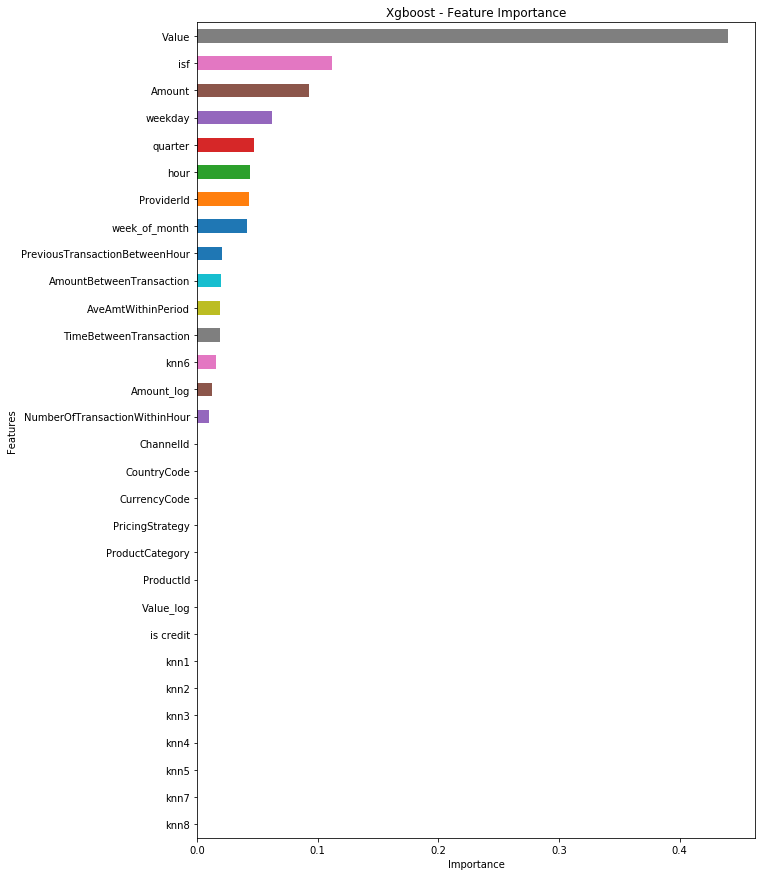

In [70]:
fea_imp = pd.DataFrame({'imp': xg.feature_importances_, 'col': a.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-50:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 15), legend=None)
plt.title('Xgboost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [71]:
xx=test.drop(['FraudResult','TransactionId','BatchId','month','AccountId',
              'SubscriptionId','CustomerId','TransactionStartTime'],axis=1)

In [72]:
xx=sc.transform(ce.transform(xx))

In [73]:
xg.predict(xx).sum()

66.0

In [74]:
#pd.DataFrame(xg.predict(xx)).to_csv('New Benchmark 3.csv',index=True)